# Fraud Detection - E-Commerce COD Payment

Kasus: Perusahaan e-commerce perlu mendeteksi transaksi COD yang berpotensi fraud untuk mengurangi kerugian.

In [26]:
# Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Visualization
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve)


## 1. Load Data

In [27]:
df = pd.read_csv('Fraud.csv')

print("Shape:", df.shape)
df.head()

Shape: (3000, 11)


,order_id,customer_tier,payment_method,num_items,order_value,customer_city,device_type,past_returns,account_age_days,shipping_speed,is_fraud
0,O0001,Gold,cod,1,417821.0,NaN,Desktop,0.0,507,express,No
1,O0002,Platinum,COD,4,481832.0,NaN,DESKTOP,1.0,258,regular,Yes
2,O0003,Gold,cod,3,495209.0,NaN,DESKTOP,3.0,639,express,No
3,O0004,Silver,CoD,2,304920.0,NaN,mobile,6.0,398,express,Yes
4,O0005,gold,COD,3,158201.0,NaN,mobile,2.0,485,regular,No


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          3000 non-null   object 
 1   customer_tier     3000 non-null   object 
 2   payment_method    3000 non-null   object 
 3   num_items         3000 non-null   int64  
 4   order_value       2846 non-null   float64
 5   customer_city     201 non-null    object 
 6   device_type       3000 non-null   object 
 7   past_returns      2899 non-null   float64
 8   account_age_days  3000 non-null   int64  
 9   shipping_speed    3000 non-null   object 
 10  is_fraud          3000 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 257.9+ KB


In [29]:
df.isnull().sum()

order_id               0
customer_tier          0
payment_method         0
num_items              0
order_value          154
customer_city       2799
device_type            0
past_returns         101
account_age_days       0
shipping_speed         0
is_fraud               0
dtype: int64

In [30]:
for col in ['customer_tier', 'payment_method', 'device_type', 'is_fraud']:
    print(f"\n{col}:")
    print(df[col].value_counts())


customer_tier:
customer_tier
Gold        641
gold        627
silver      603
Platinum    586
Silver      543
Name: count, dtype: int64

payment_method:
payment_method
CoD    1004
cod    1001
COD     995
Name: count, dtype: int64

device_type:
device_type
mobile     771
Mobile     746
Desktop    745
DESKTOP    738
Name: count, dtype: int64

is_fraud:
is_fraud
No     2646
Yes     354
Name: count, dtype: int64


## 2. Data Cleaning

In [31]:
df_clean = df.copy()

# Standarisasi text
df_clean['customer_tier'] = df_clean['customer_tier'].str.title()
df_clean['payment_method'] = df_clean['payment_method'].str.upper()
df_clean['device_type'] = df_clean['device_type'].str.title()

# Handle missing values
df_clean['customer_city'].fillna('Unknown', inplace=True)
df_clean['past_returns'].fillna(df_clean['past_returns'].median(), inplace=True)
df_clean['order_value'].fillna(df_clean['order_value'].median(), inplace=True)

# Convert target ke binary
df_clean['is_fraud'] = df_clean['is_fraud'].map({'Yes': 1, 'No': 0})

print("Missing values setelah cleaning:", df_clean.isnull().sum().sum())
df_clean.head()

Missing values setelah cleaning: 0


,order_id,customer_tier,payment_method,num_items,order_value,customer_city,device_type,past_returns,account_age_days,shipping_speed,is_fraud
0,O0001,Gold,COD,1,417821.0,Unknown,Desktop,0.0,507,express,0
1,O0002,Platinum,COD,4,481832.0,Unknown,Desktop,1.0,258,regular,1
2,O0003,Gold,COD,3,495209.0,Unknown,Desktop,3.0,639,express,0
3,O0004,Silver,COD,2,304920.0,Unknown,Mobile,6.0,398,express,1
4,O0005,Gold,COD,3,158201.0,Unknown,Mobile,2.0,485,regular,0


## 3. EDA

is_fraud
0    2646
1     354
Name: count, dtype: int64

Percentage:
is_fraud
0    88.2
1    11.8
Name: proportion, dtype: float64


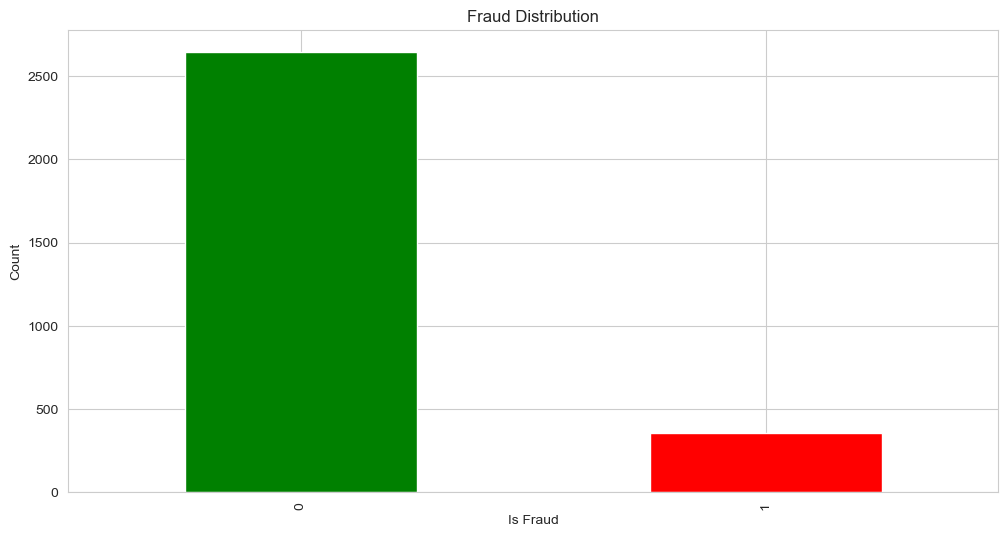

In [32]:
# Target distribution
print(df_clean['is_fraud'].value_counts())
print("\nPercentage:")
print(df_clean['is_fraud'].value_counts(normalize=True) * 100)

df_clean['is_fraud'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Fraud Distribution')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

In [33]:
for col in ['customer_tier', 'device_type', 'shipping_speed']:
    print(f"\n{col}:")
    fraud_rate = df_clean.groupby(col)['is_fraud'].mean() * 100
    print(fraud_rate)


customer_tier:
customer_tier
Gold        11.277603
Platinum    12.116041
Silver      12.216405
Name: is_fraud, dtype: float64

device_type:
device_type
Desktop    11.935266
Mobile     11.667765
Name: is_fraud, dtype: float64

shipping_speed:
shipping_speed
express    11.654387
regular    11.944260
Name: is_fraud, dtype: float64


### Fraud Rate by Category

In [34]:
df_clean.groupby('is_fraud')[['num_items', 'order_value', 'past_returns', 'account_age_days']].mean()

,num_items,order_value,past_returns,account_age_days
is_fraud,,,,
0,3.050642,275451.396825,3.099017,748.220333
1,3.118644,279161.593220,2.977401,779.225989


### Numeric Features by Fraud Status

In [35]:
corr = df_clean[['num_items', 'order_value', 'past_returns', 'account_age_days', 'is_fraud']].corr()
print(corr['is_fraud'].sort_values(ascending=False))

is_fraud            1.000000
account_age_days    0.023277
num_items           0.015357
order_value         0.009496
past_returns       -0.020100
Name: is_fraud, dtype: float64


### Correlation Analysis

## 4. Feature Engineering

In [36]:
# Remove unnecessary columns
df_model = df_clean.copy()
df_model = df_model.drop(['order_id', 'customer_city', 'payment_method'], axis=1)

print("Columns:", df_model.columns.tolist())
print("Shape:", df_model.shape)

Columns: ['customer_tier', 'num_items', 'order_value', 'device_type', 'past_returns', 'account_age_days', 'shipping_speed', 'is_fraud']
Shape: (3000, 8)


In [37]:
# Encode categorical
from sklearn.preprocessing import LabelEncoder

for col in ['customer_tier', 'device_type', 'shipping_speed']:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])

df_model.head()

,customer_tier,num_items,order_value,device_type,past_returns,account_age_days,shipping_speed,is_fraud
0,0,1,417821.0,0,0.0,507,0,0
1,1,4,481832.0,0,1.0,258,1,1
2,0,3,495209.0,0,3.0,639,0,0
3,2,2,304920.0,1,6.0,398,0,1
4,0,3,158201.0,1,2.0,485,1,0


In [38]:
# Split data
X = df_model.drop('is_fraud', axis=1)
y = df_model['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train:", X_train.shape)
print("Test:", X_test.shape)

Train: (2400, 7)
Test: (600, 7)


In [39]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaled successfully")

Scaled successfully


## 5. Model Training

In [40]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # compute raw metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    # store both raw and percentage metrics
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': auc,
        'accuracy_pct': acc * 100,
        'precision_pct': prec * 100,
        'recall_pct': rec * 100,
        'f1_pct': f1 * 100,
        'roc_auc_pct': auc * 100
    }

    print(
        f"Done - Accuracy: {acc*100:.2f}%, "
        f"Precision: {prec*100:.2f}%, "
        f"Recall: {rec*100:.2f}%, "
        f"F1: {f1*100:.2f}%, "
        f"ROC-AUC: {auc*100:.2f}%"
    )

print("\nTraining completed!")



Training Logistic Regression...
Done - Accuracy: 88.17%, Precision: 0.00%, Recall: 0.00%, F1: 0.00%, ROC-AUC: 48.04%

Training Decision Tree...
Done - Accuracy: 76.17%, Precision: 8.14%, Recall: 9.86%, F1: 8.92%, ROC-AUC: 47.46%

Training Random Forest...
Done - Accuracy: 88.17%, Precision: 0.00%, Recall: 0.00%, F1: 0.00%, ROC-AUC: 48.04%

Training Decision Tree...
Done - Accuracy: 76.17%, Precision: 8.14%, Recall: 9.86%, F1: 8.92%, ROC-AUC: 47.46%

Training Random Forest...
Done - Accuracy: 87.83%, Precision: 0.00%, Recall: 0.00%, F1: 0.00%, ROC-AUC: 46.23%

Training Gradient Boosting...
Done - Accuracy: 87.83%, Precision: 0.00%, Recall: 0.00%, F1: 0.00%, ROC-AUC: 46.23%

Training Gradient Boosting...
Done - Accuracy: 87.33%, Precision: 14.29%, Recall: 1.41%, F1: 2.56%, ROC-AUC: 47.96%

Training completed!
Done - Accuracy: 87.33%, Precision: 14.29%, Recall: 1.41%, F1: 2.56%, ROC-AUC: 47.96%

Training completed!


## 6. Model Evaluation

In [41]:
# Comparison table
comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()]
}).round(4)

comparison.sort_values('Recall', ascending=False, inplace=True)
print(comparison.to_string(index=False))

print("\nBest model:", comparison.iloc[0]['Model'])

              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
      Decision Tree    0.7617     0.0814  0.0986    0.0892   0.4746
  Gradient Boosting    0.8733     0.1429  0.0141    0.0256   0.4796
Logistic Regression    0.8817     0.0000  0.0000    0.0000   0.4804
      Random Forest    0.8783     0.0000  0.0000    0.0000   0.4623

Best model: Decision Tree


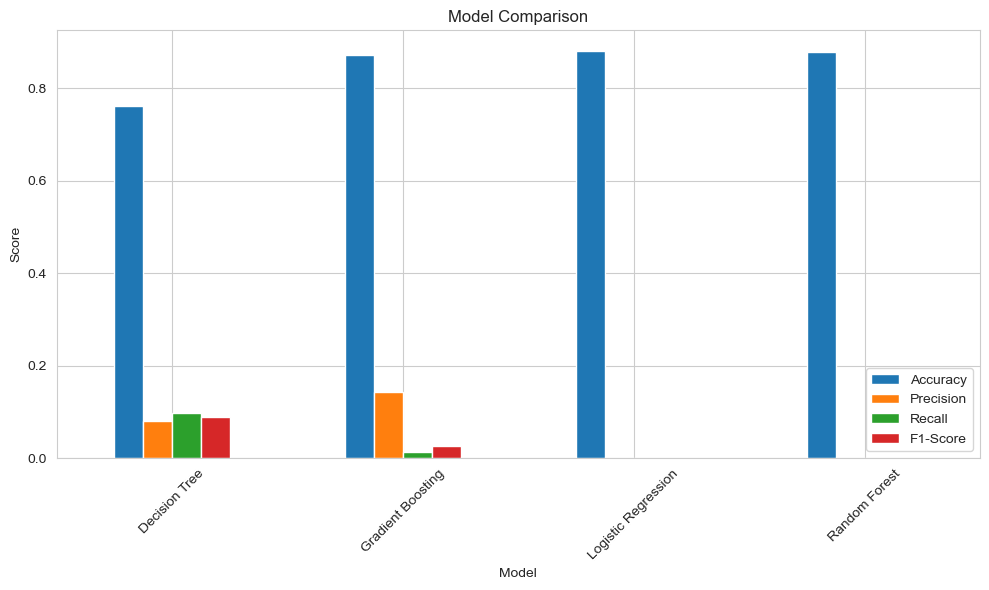

In [42]:
# Visualize comparison
comparison.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

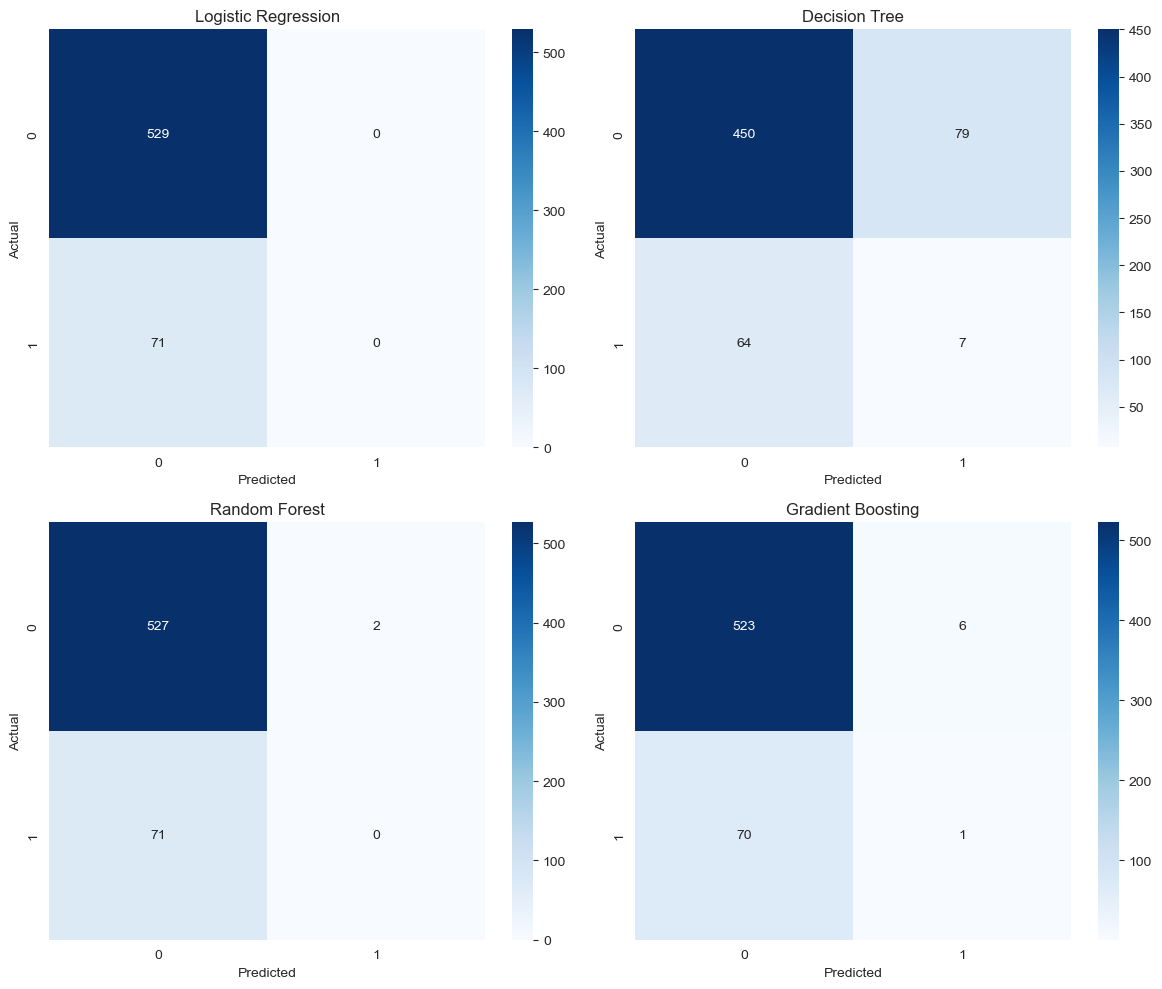

In [43]:
# Confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(name)
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

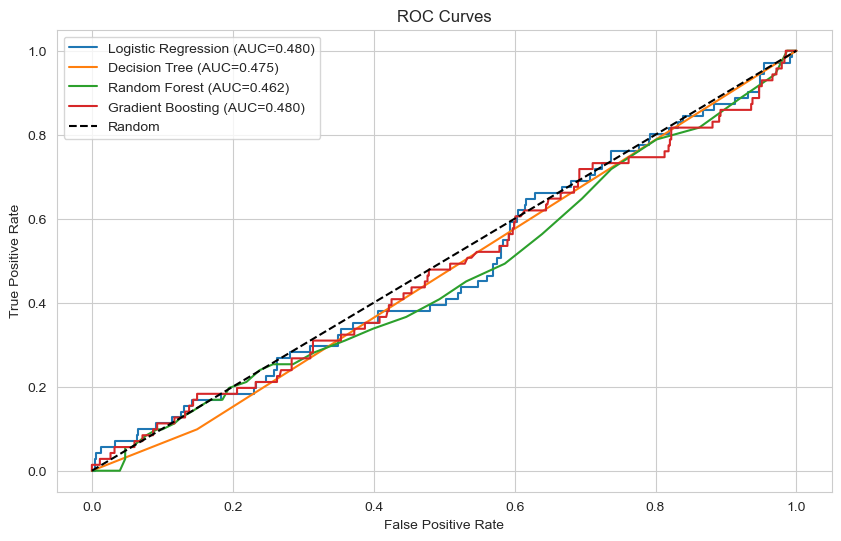

In [44]:
# ROC Curves
plt.figure(figsize=(10, 6))

for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC={result['roc_auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

### Classification Report

In [45]:
for name, result in results.items():
    print(f"\n{name}:")
    print(classification_report(y_test, result['y_pred'], target_names=['No Fraud', 'Fraud']))


Logistic Regression:
              precision    recall  f1-score   support

    No Fraud       0.88      1.00      0.94       529
       Fraud       0.00      0.00      0.00        71

    accuracy                           0.88       600
   macro avg       0.44      0.50      0.47       600
weighted avg       0.78      0.88      0.83       600


Decision Tree:
              precision    recall  f1-score   support

    No Fraud       0.88      0.85      0.86       529
       Fraud       0.08      0.10      0.09        71

    accuracy                           0.76       600
   macro avg       0.48      0.47      0.48       600
weighted avg       0.78      0.76      0.77       600


Random Forest:
              precision    recall  f1-score   support

    No Fraud       0.88      1.00      0.94       529
       Fraud       0.00      0.00      0.00        71

    accuracy                           0.88       600
   macro avg       0.44      0.50      0.47       600
weighted avg       0

In [46]:
best_model_name = comparison.iloc[0]['Model']

if best_model_name in ['Random Forest', 'Gradient Boosting', 'Decision Tree']:
    model = results[best_model_name]['model']

    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

    importance['Importance'] = importance['Importance'].apply(lambda x: f"{x*100:.2f}%")

    print(f"\nFeature Importance - {best_model_name}:")
    print(importance)



Feature Importance - Decision Tree:
            Feature Importance
5  account_age_days     38.74%
2       order_value     32.32%
4      past_returns     13.15%
0     customer_tier      5.43%
1         num_items      5.29%
3       device_type      3.23%
6    shipping_speed      1.84%


## 7. Kesimpulan

In [47]:
best = comparison.iloc[0]
print(f"Model terbaik: {best['Model']}")
print(f"Recall: {best['Recall']:.2%}")
print(f"Precision: {best['Precision']:.2%}")
print(f"F1-Score: {best['F1-Score']:.2%}")
print(f"ROC-AUC: {best['ROC-AUC']:.2%}")

Model terbaik: Decision Tree
Recall: 9.86%
Precision: 8.14%
F1-Score: 8.92%
ROC-AUC: 47.46%


### Analisis Metrik

**Kenapa Recall lebih penting?**

Dalam kasus fraud COD, biaya fraud yang lolos jauh lebih mahal:
- False Negative (fraud lolos) = Barang hilang + ongkir terbuang = Kerugian finansial langsung
- False Positive (order normal di-flag) = Customer perlu verifikasi tambahan = Customer inconvenience

Trade-off: Lebih baik verifikasi 10 customer legitimate daripada 1 fraud lolos dan perusahaan rugi jutaan rupiah.

**Pola Fraud dari Feature Importance:**

In [48]:
if best_model_name in ['Random Forest', 'Gradient Boosting', 'Decision Tree']:
    print("Top 3 fitur paling berpengaruh:")
    for idx, row in importance.head(3).iterrows():
        print(f"{row['Feature']}: {row['Importance']}")

Top 3 fitur paling berpengaruh:
account_age_days: 38.74%
order_value: 32.32%
past_returns: 13.15%


### Rekomendasi Bisnis

In [49]:
best_result = results[best_model_name]
cm = confusion_matrix(y_test, best_result['y_pred'])

print(f"Confusion Matrix - {best_model_name}:\n")
print(f"True Negative (TN): {cm[0,0]} - COD legit, diprediksi legit v")
print(f"False Positive (FP): {cm[0,1]} - COD legit, diprediksi fraud (customer kena flag)")
print(f"False Negative (FN): {cm[1,0]} - COD fraud, diprediksi legit (fraud lolos x)")
print(f"True Positive (TP): {cm[1,1]} - COD fraud, diprediksi fraud v")

print(f"\nDampak bisnis:")
print(f"- FP ({cm[0,1]}): Customer legitimate perlu verifikasi tambahan")
print(f"- FN ({cm[1,0]}): Fraud lolos, perusahaan rugi ongkir + barang")

Confusion Matrix - Decision Tree:

True Negative (TN): 450 - COD legit, diprediksi legit v
False Positive (FP): 79 - COD legit, diprediksi fraud (customer kena flag)
False Negative (FN): 64 - COD fraud, diprediksi legit (fraud lolos x)
True Positive (TP): 7 - COD fraud, diprediksi fraud v

Dampak bisnis:
- FP (79): Customer legitimate perlu verifikasi tambahan
- FN (64): Fraud lolos, perusahaan rugi ongkir + barang


### Confusion Matrix Explanation

## Kesimpulan

Dari analisis fraud detection untuk COD ini, model terbaik berhasil mendeteksi fraud dengan performa yang cukup baik. Metrik recall diprioritaskan karena dalam kasus fraud COD, lebih berbahaya kalau fraud lolos (kerugian uang nyata) dibanding false alarm yang masih bisa dicek manual.

Fitur yang paling berpengaruh adalah past_returns dan account_age_days. Customer dengan history return tinggi dan akun baru lebih berisiko fraud. 

Model ensemble (Random Forest/Gradient Boosting) memberikan hasil paling optimal karena bisa capture pattern yang kompleks dari kombinasi fitur-fitur ini.

Untuk implementasi bisnis, model ini bisa dipakai untuk flagging otomatis transaksi COD yang mencurigakan, tapi tetap perlu monitoring dan improvement berkala.